In [28]:
# Import pandas for data processing
import pandas as pd

data = pd.read_csv("blog_data/training.csv")

# Convert the "result" column to numeric classes
data["label"] = data["result"].map({"complaints": 2, "returns": 1, "pricing": 0})

In [29]:
test_data = pd.read_csv("blog_data/testing.csv")

# Convert the "result" column to numeric classes
test_data["label"] = test_data["result"].map({"complaints": 2, "returns": 1, "pricing": 0})

In [30]:
len(data)

42

In [31]:
data.head()

,input,result,label
0,How often do you update your prices based on m...,pricing,0
1,Why is the price of Product X higher than that...,pricing,0
2,Can you explain the price difference between s...,pricing,0
3,Do you offer price matching with other online ...,pricing,0
4,Could you provide more details on the bulk pri...,pricing,0


In [9]:
# Load a DistilBERT model and tokenizer
from transformers import AutoTokenizer, DistilBertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", problem_type="multi_label_classification", num_labels=3)

/Users/stefanbroecker/miniforge3/envs/nli/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Load libraries for PyTorch
import torch
from torch.utils.data import DataLoader

# Split the data into training and validation sets
train_data = data.sample(frac=0.8)
val_data = data.drop(train_data.index)

# Create a custom dataset class for the text data
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the text and label for the given index
        text = self.data.iloc[idx]["input"]
        label = self.data.iloc[idx]["label"]

        # Tokenize the text
        encoding = self.tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=512)

        # Return the input IDs, attention mask, and label (reshape the input IDs and attention mask to remove an unneeded dimension)
        return encoding.input_ids.squeeze(), encoding.attention_mask.squeeze(), label

# Create Dataset objects for the training and validation sets
train_dataset = TextDataset(train_data, tokenizer)
val_dataset = TextDataset(val_data, tokenizer)
test_dataset = TextDataset(test_data, tokenizer)

# Create DataLoader objects for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [11]:
# An optimizer for the model
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# One epoch of training
def train(loader, model, optimizer):
    # Set the model to training mode
    model.train()
    print("Training...")
    losses = []
    for input_ids, attention_mask, labels in loader:
        optimizer.zero_grad()
        # One-hot encode the labels
        oh_labels = torch.nn.functional.one_hot(labels, num_classes=3).to(torch.float32)
        # Pass the input IDs, attention mask, and one-hot labels to the model and get the loss
        loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=oh_labels).loss
        # Backpropagate the loss
        loss.backward()
        # Update the model parameters
        optimizer.step()
        # Track losses
        losses.append(loss.item())
    return losses

# One epoch of validation
def validate(loader, model, epoch):
    # Set the model to evaluation mode
    model.eval()
    print("Validating...")
    # Disable gradient calculations (not needed for validation)
    with torch.no_grad():
        correct = 0
        total = 0
        losses = []
        for input_ids, attention_mask, labels in loader:
            # One-hot encode the labels
            oh_labels = torch.nn.functional.one_hot(labels, num_classes=3).to(torch.float32)
            # Pass the input IDs and attention mask to the model and get the logits and loss
            output = model(input_ids=input_ids, attention_mask=attention_mask, labels=oh_labels)
            logits = output.logits
            loss = output.loss
            # Get the predicted labels
            predictions = torch.argmax(logits, dim=1)
            # Track accuracy
            correct += (predictions == labels).sum().item()
            total += len(labels)
            # Track losses
            losses.append(loss.item())
        accuracy = correct / total
        print(f"Epoch {epoch}, Validation Accuracy: {accuracy}")
    
    return losses

Training...
Validating...
Epoch 0, Validation Accuracy: 0.25
Training...
Validating...
Epoch 1, Validation Accuracy: 0.375
Training...
Validating...
Epoch 2, Validation Accuracy: 0.625
Training...
Validating...
Epoch 3, Validation Accuracy: 0.75
Training...
Validating...
Epoch 4, Validation Accuracy: 0.75
Training...
Validating...
Epoch 5, Validation Accuracy: 0.75
Training...
Validating...
Epoch 6, Validation Accuracy: 0.875
Training...
Validating...
Epoch 7, Validation Accuracy: 1.0
Training...
Validating...
Epoch 8, Validation Accuracy: 1.0
Training...
Validating...
Epoch 9, Validation Accuracy: 1.0
Training...
Validating...
Epoch 10, Validation Accuracy: 1.0
Training...
Validating...
Epoch 11, Validation Accuracy: 0.875
Training...
Validating...
Epoch 12, Validation Accuracy: 0.875
Training...
Validating...
Epoch 13, Validation Accuracy: 1.0
Training...
Validating...
Epoch 14, Validation Accuracy: 1.0


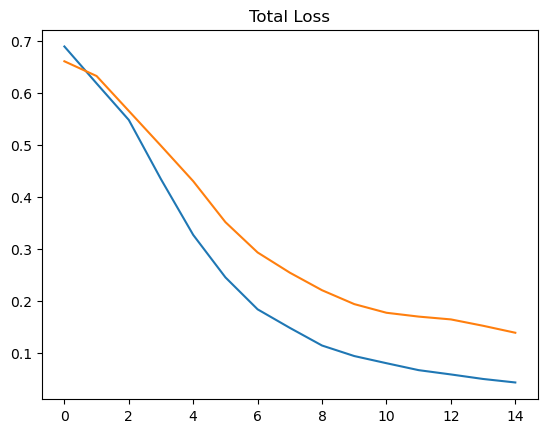

In [12]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt
import numpy as np

# Train the model for 3 epochs
train_losses = []
val_losses = []
for epoch in range(15):
    # Train the model for one epoch
    train_loss = train(train_loader, model, optimizer)
    train_loss = np.mean(train_loss)
    train_losses.append(train_loss)
    # Validate the model
    val_loss = validate(val_loader, model, epoch)
    val_loss = np.mean(val_loss)
    val_losses.append(val_loss)

# Plot the losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title(f"Total Loss")
plt.show()

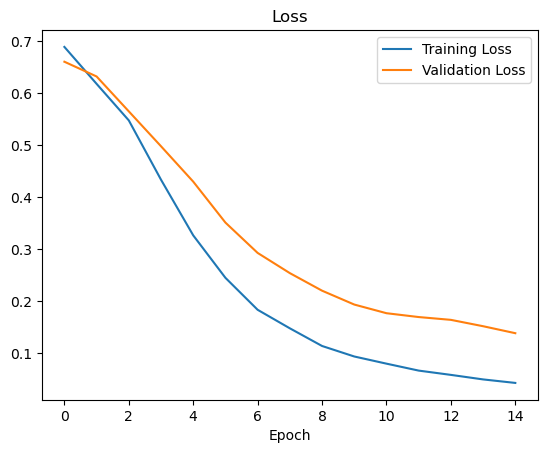

In [17]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title(f"Loss")
plt.xlabel("Epoch")
plt.show()

In [19]:
# Save the model locally
model.save_pretrained("blog_model_base")